In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
import itertools

In [19]:
path = "data.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


data = pd.read_csv(path)
#data.sort_values(by=['id'])

display(data.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [20]:
#Remove unnecessary variables
data = data.drop(['id', 'Unnamed: 32'], axis = 1)

y = np.array(data.diagnosis.tolist())
data2 = data.copy()
data2.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

#Replace diagnosis values (M = 1, B = 0)
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
display(data.head())
display(data.describe())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Logistic Regression

In [21]:
#Scaling and Splitting Data
y = np.array(data.diagnosis.tolist())
data = data.drop('diagnosis', axis=1)
X = data.values

#Normalizing the Data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Splitting the Data
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = random_state)

In [22]:
#Logistic Regression
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty': ['l1', 'l2'],  
            'solver': ['liblinear'],
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [23]:
# Accessing coefficients
coefficients = CV_log_clf.best_estimator_.coef_

# Outputting coefficients
print("Coefficients:")
for i, coef in enumerate(coefficients[0]):
    print(f"Coefficient for feature {i + 1}: {coef}")

Coefficients:
Coefficient for feature 1: 0.36365307094544297
Coefficient for feature 2: 0.4074393127528309
Coefficient for feature 3: 0.3529376427600434
Coefficient for feature 4: 0.3794043268232813
Coefficient for feature 5: 0.12682831311848605
Coefficient for feature 6: -0.029350417935999563
Coefficient for feature 7: 0.38782449793216595
Coefficient for feature 8: 0.4695575981337264
Coefficient for feature 9: 0.08404965184017221
Coefficient for feature 10: -0.2165399524055209
Coefficient for feature 11: 0.515401121391353
Coefficient for feature 12: -0.025325117178481602
Coefficient for feature 13: 0.3702632609240722
Coefficient for feature 14: 0.4127113372849948
Coefficient for feature 15: 0.10052371499309481
Coefficient for feature 16: -0.26630051330797094
Coefficient for feature 17: -0.0687305907073329
Coefficient for feature 18: 0.10021742829318461
Coefficient for feature 19: -0.13301222278020353
Coefficient for feature 20: -0.25309044898746136
Coefficient for feature 21: 0.512019

In [24]:
odds_ratios = np.exp(coefficients)

# Outputting odds ratios
print("Odds Ratios:")
for i, coef in enumerate(odds_ratios[0]):
    print(f"Odds Ratio for feature {i + 1}: {coef}")

Odds Ratios:
Odds Ratio for feature 1: 1.4385750440947966
Odds Ratio for feature 2: 1.5029642320045415
Odds Ratio for feature 3: 1.423242391199154
Odds Ratio for feature 4: 1.4614138051047514
Odds Ratio for feature 5: 1.1352220983075227
Odds Ratio for feature 6: 0.9710761223486043
Odds Ratio for feature 7: 1.4737711117124
Odds Ratio for feature 8: 1.5992865093521276
Odds Ratio for feature 9: 1.087682897925519
Odds Ratio for feature 10: 0.8053003605933824
Odds Ratio for feature 11: 1.6743099686628509
Odds Ratio for feature 12: 0.9749928735617074
Odds Ratio for feature 13: 1.44811579678877
Odds Ratio for feature 14: 1.5109088199367307
Odds Ratio for feature 15: 1.1057498642435377
Odds Ratio for feature 16: 0.7662088369478764
Odds Ratio for feature 17: 0.9335781608330143
Odds Ratio for feature 18: 1.1054112396274478
Odds Ratio for feature 19: 0.8754543915567699
Odds Ratio for feature 20: 0.7763976542660842
Odds Ratio for feature 21: 1.6686578115340118
Odds Ratio for feature 22: 1.78204177

In [25]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

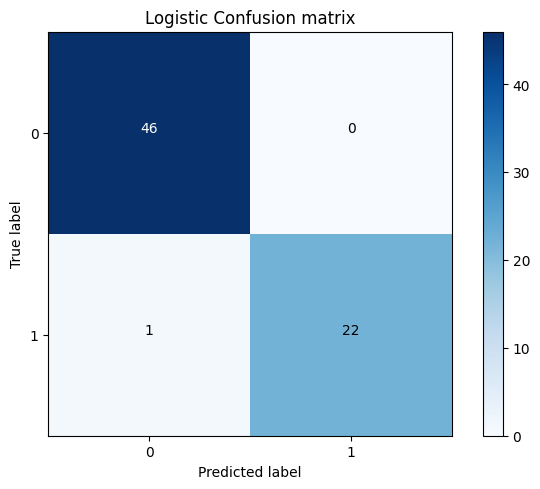

Accuracy  =     0.986
Precision =     1.000
Recall    =     0.957
F1_score  =     0.978


In [26]:
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
# plt.savefig('6')
plt.show()

show_metrics()

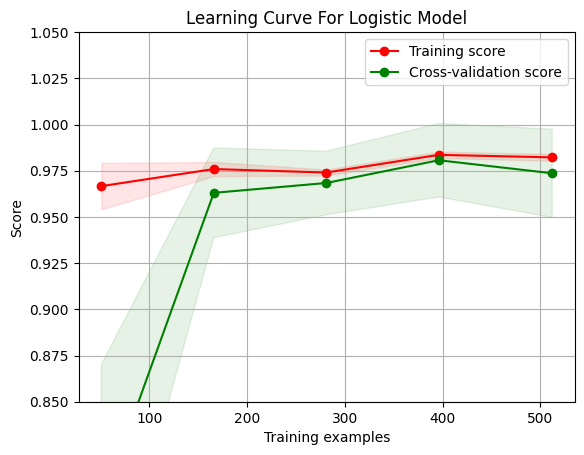

In [27]:
# Plotting Learning Curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.85,1.05), 10)
plt.show()

In [28]:
# Cross Validation
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

cross_log = cross_val_metrics(CV_log_clf)

[accuracy] : 0.97541 (+/- 0.00653)
[precision] : 0.99024 (+/- 0.01196)
[recall] : 0.94352 (+/- 0.01856)


In [29]:
cv_scores = cross_val_score(CV_log_clf, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.99 0.98 0.97 0.97 0.97]
Mean cross-validation score: 0.976


Decision Tree

In [30]:
path = "data.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)


data = pd.read_csv(path)
#data.sort_values(by=['id'])

display(data.head())

data.drop(['id', 'Unnamed: 32'], axis = 1, inplace=True)
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [31]:
#remove highly correlated features
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
corr_matrix = data.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
tri_df = corr_matrix.mask(mask)

to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.92)]

df = data.drop(to_drop, axis = 1)

X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

#Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.12, random_state = 42)

In [32]:
#standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dtc = DecisionTreeClassifier(random_state=42)

#searching through parameters to find best one
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 32, 1),
    'min_samples_leaf' : range(1, 10, 1),
    'min_samples_split' : range(2, 10, 1),
    'splitter' : ['best', 'random']
}

grid_search_dt = GridSearchCV(dtc, parameters, cv = 5, n_jobs = -1, verbose = 1)
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 8640 candidates, totalling 43200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 32),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']},
             verbose=1)

In [33]:
#print best parameters
grid_search_dt.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'random'}

In [34]:
#best mean cross-validated score schieved during search
grid_search_dt.best_score_

0.95

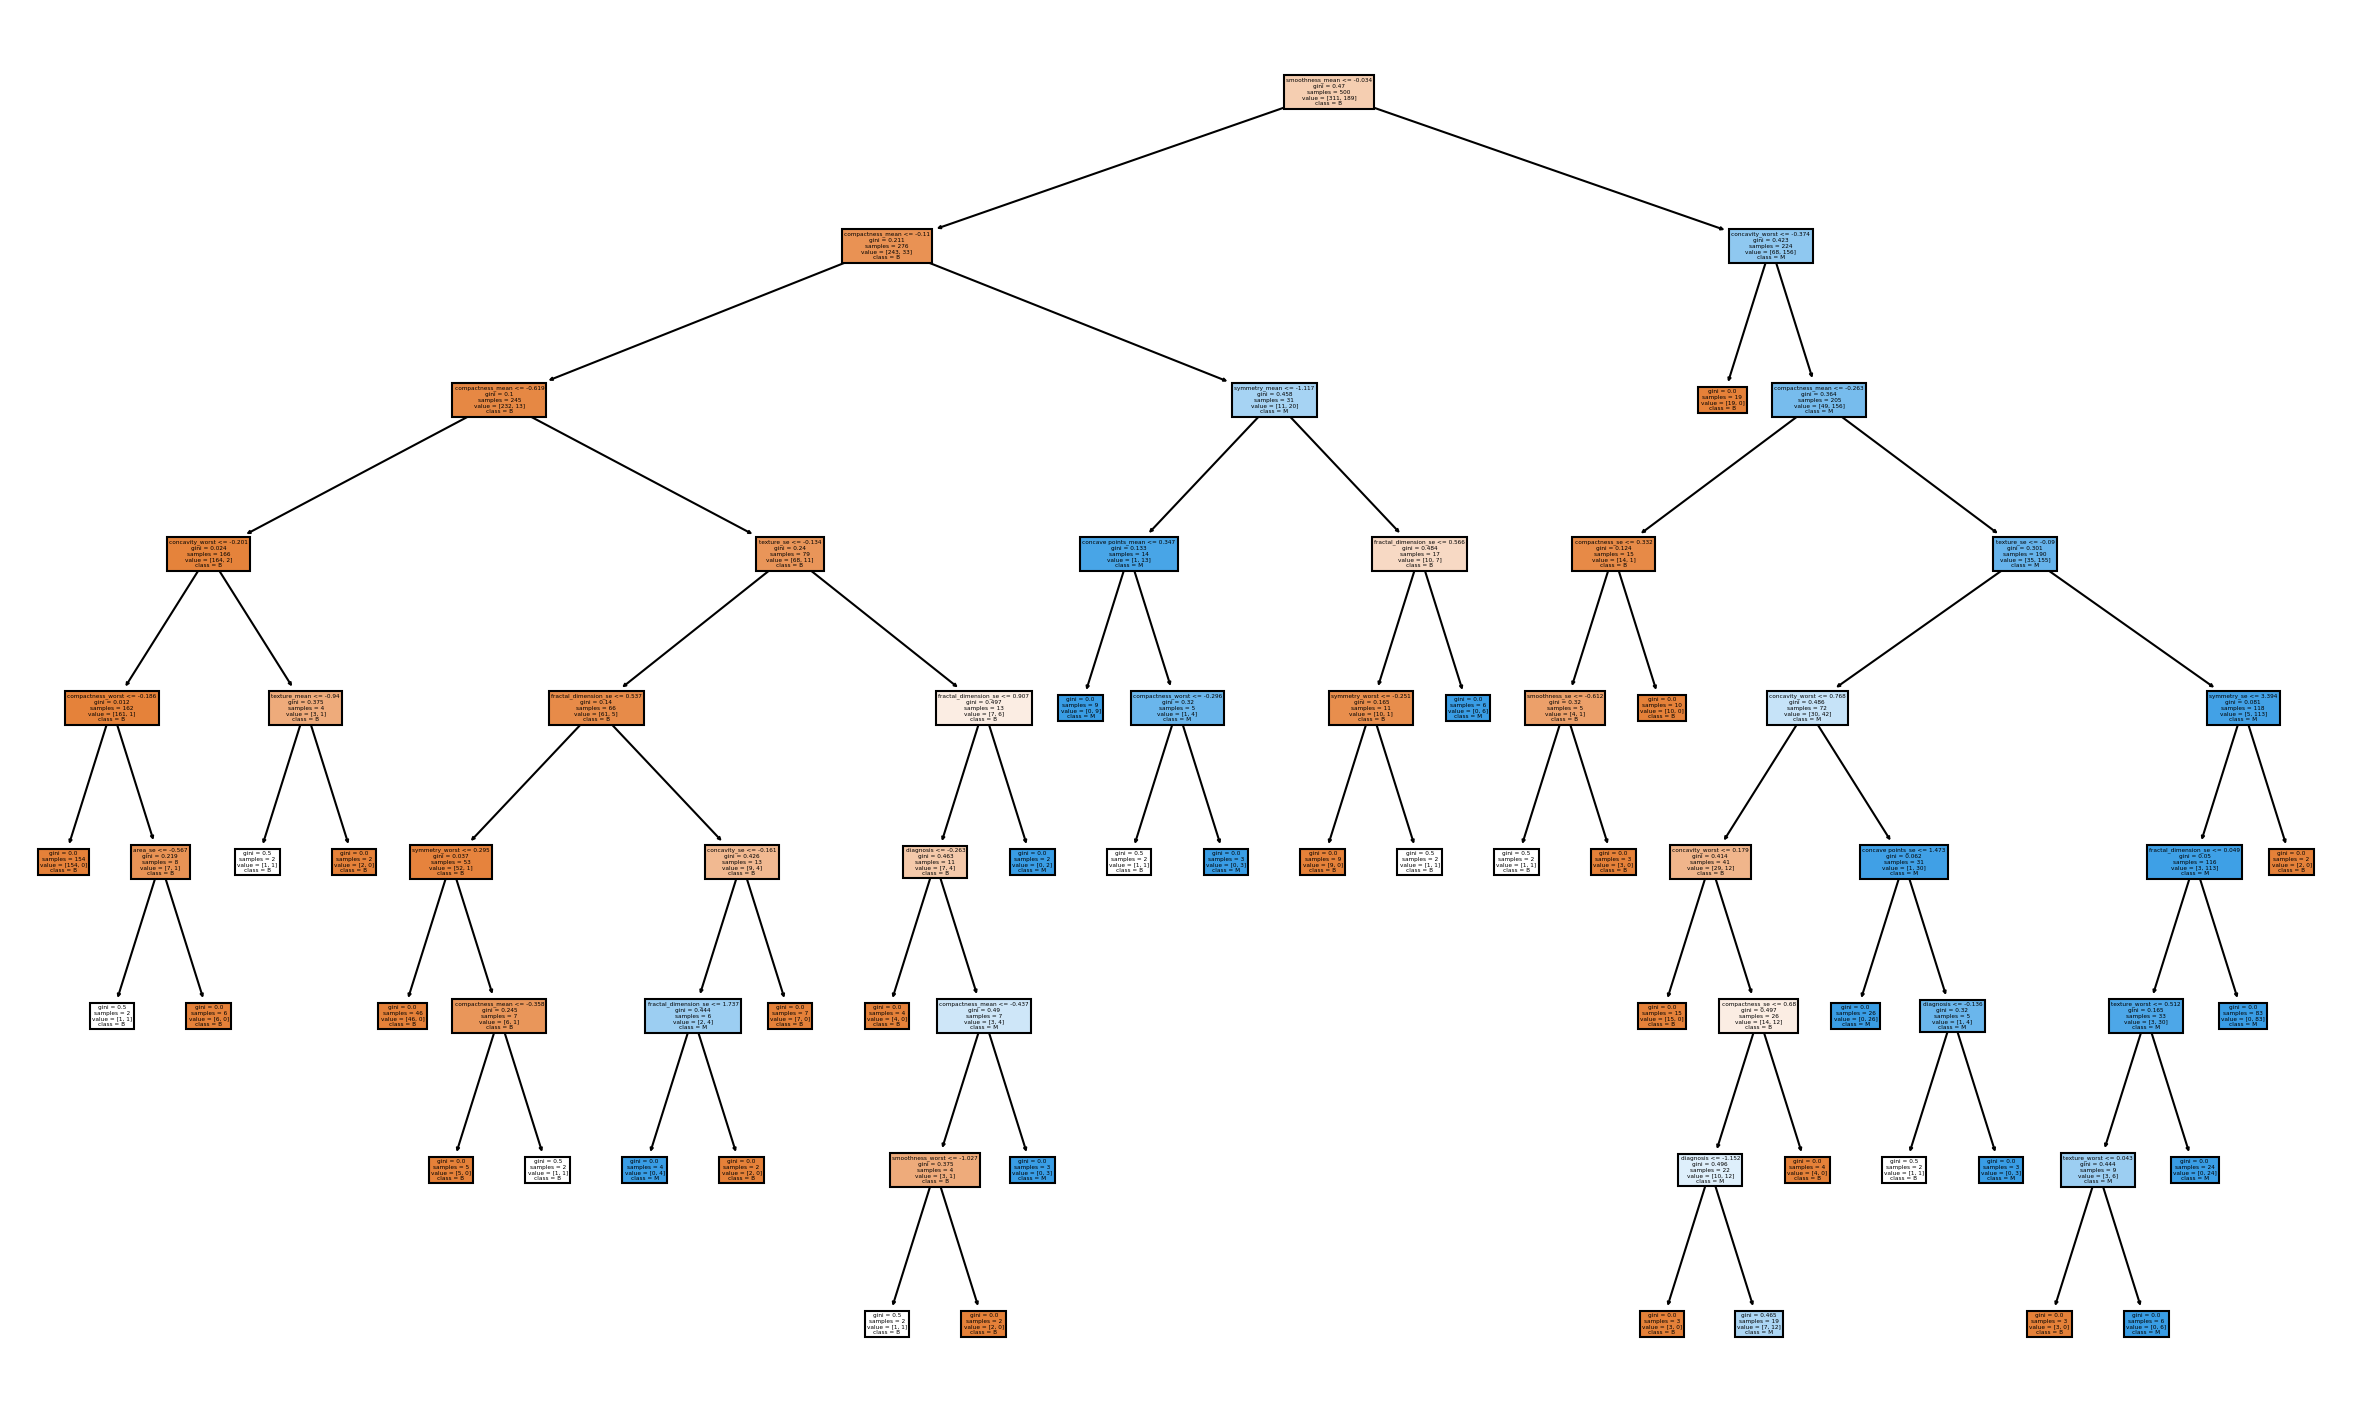

In [35]:
dtc = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_leaf = 2, min_samples_split = 2, splitter = 'random')
dtc.fit(X_train, y_train)

# Visualize decision tree
plt.figure(figsize=(20, 12), dpi=150)
tree.plot_tree(dtc, feature_names=df.columns[:-1], class_names=["B", "M"], filled=True)
plt.show()

0.97
0.9565217391304348
[[44  2]
 [ 1 22]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.92      0.96      0.94        23

    accuracy                           0.96        69
   macro avg       0.95      0.96      0.95        69
weighted avg       0.96      0.96      0.96        69



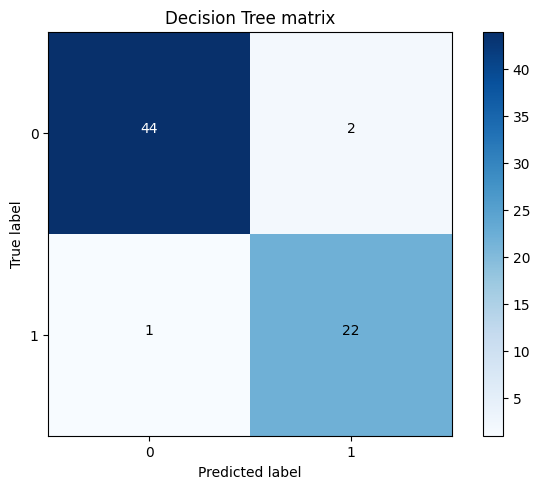

In [36]:
y_pred = dtc.predict(X_test)

print(accuracy_score(y_train, dtc.predict(X_train)))

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))
print(dtc_acc)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Decision Tree matrix')
# plt.savefig('6')
plt.show()

In [37]:
#cross validation

cv_scores = cross_val_score(dtc, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.96 0.94 0.93 0.93 0.94]
Mean cross-validation score: 0.9400000000000001


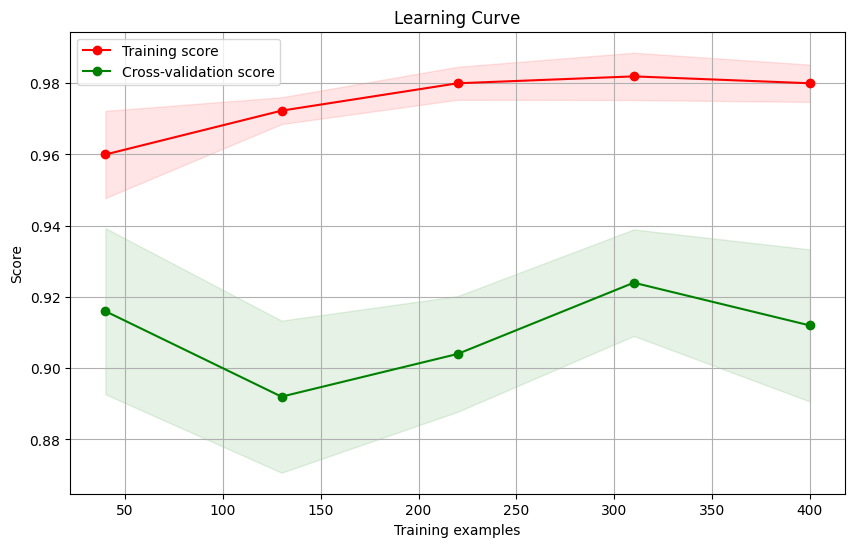

In [38]:
#learning curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(dtc, X_train, y_train, cv=5)

Random Forest

In [39]:
#parameters
parameters = {
    'criterion': ['gini', 'entropy'], 
    'n_estimators': (10, 400), 
    'max_depth': (1, 11),        
    'min_samples_split': (2, 20), 
    'min_samples_leaf': (2, 20),  
}

rand_clf = RandomForestClassifier(random_state=42)

#bayesian optim.
bayes_search = BayesSearchCV(
    rand_clf,
    parameters,
    n_iter=100,    
    cv=5,         
    random_state=42
)
bayes_search.fit(X_train, y_train)

#get best rf classifier after hypertune
best_rf_classifier = bayes_search.best_estimator_
print(best_rf_classifier)

#predict
y_pred = best_rf_classifier.predict(X_test)
y_train_pred = best_rf_classifier.predict(X_train)

NameError: name 'BayesSearchCV' is not defined

In [ ]:
y_train_pred = best_rf_classifier.predict(X_train)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Best Model):\n", cm)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

In [ ]:
#performance metrics
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

# show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))
    
#plotting learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

#cross val
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [ ]:
#visualize / charts / 
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=['0', '1'], normalize=False, title='Random Forest Confusion Matrix')
plt.show()
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)
cross_val_metrics(best_rf_classifier)
plot_learning_curve(best_rf_classifier, "Learning Curve for Random Forest", X_scaled, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5))
cv_scores = cross_val_score(best_rf_classifier, X_scaled, y, cv=5)
print("Cross-Validation Scores:", cv_scores)


In [ ]:
#feature importance
top_ten_indices = indices[:10]
top_ten_importances = importances[top_ten_indices]
top_ten_features = X.columns[top_ten_indices]

#plot
plt.figure(figsize=(10, 6))
plt.title("Top Ten Feature Importances")
plt.bar(range(10), top_ten_importances, align="center")
plt.xticks(range(10), top_ten_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
#model comparison
bdata = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [0.986, 0.96, 0.97],
    'Precision': [1.00, 0.96, 0.97],
    'Recall': [0.957, 0.96, 0.97],
    'F1-score': [0.978, 0.96, 0.97]
}

# Create DataFrame
df = pd.DataFrame(bdata)

# Display table
print(df)

# Create bar plot
df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1-score'], kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()